In [27]:
from IPython.display import display
from ipywidgets import FloatProgress

import sys
sys.path.append('../src')

import neuralnetworkclassifier as nnc
import mlutils as ml
import perturb as per

import numpy as np
import pandas as pd
import itertools
import copy
import pickle
import glob

import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
plt.style.use('seaborn-whitegrid')

In [2]:
!curl -O http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar -xvf cifar-10-python.tar.gz


cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


(50000, 3, 32, 32) (50000, 1) (10000, 3, 32, 32) (10000, 1)


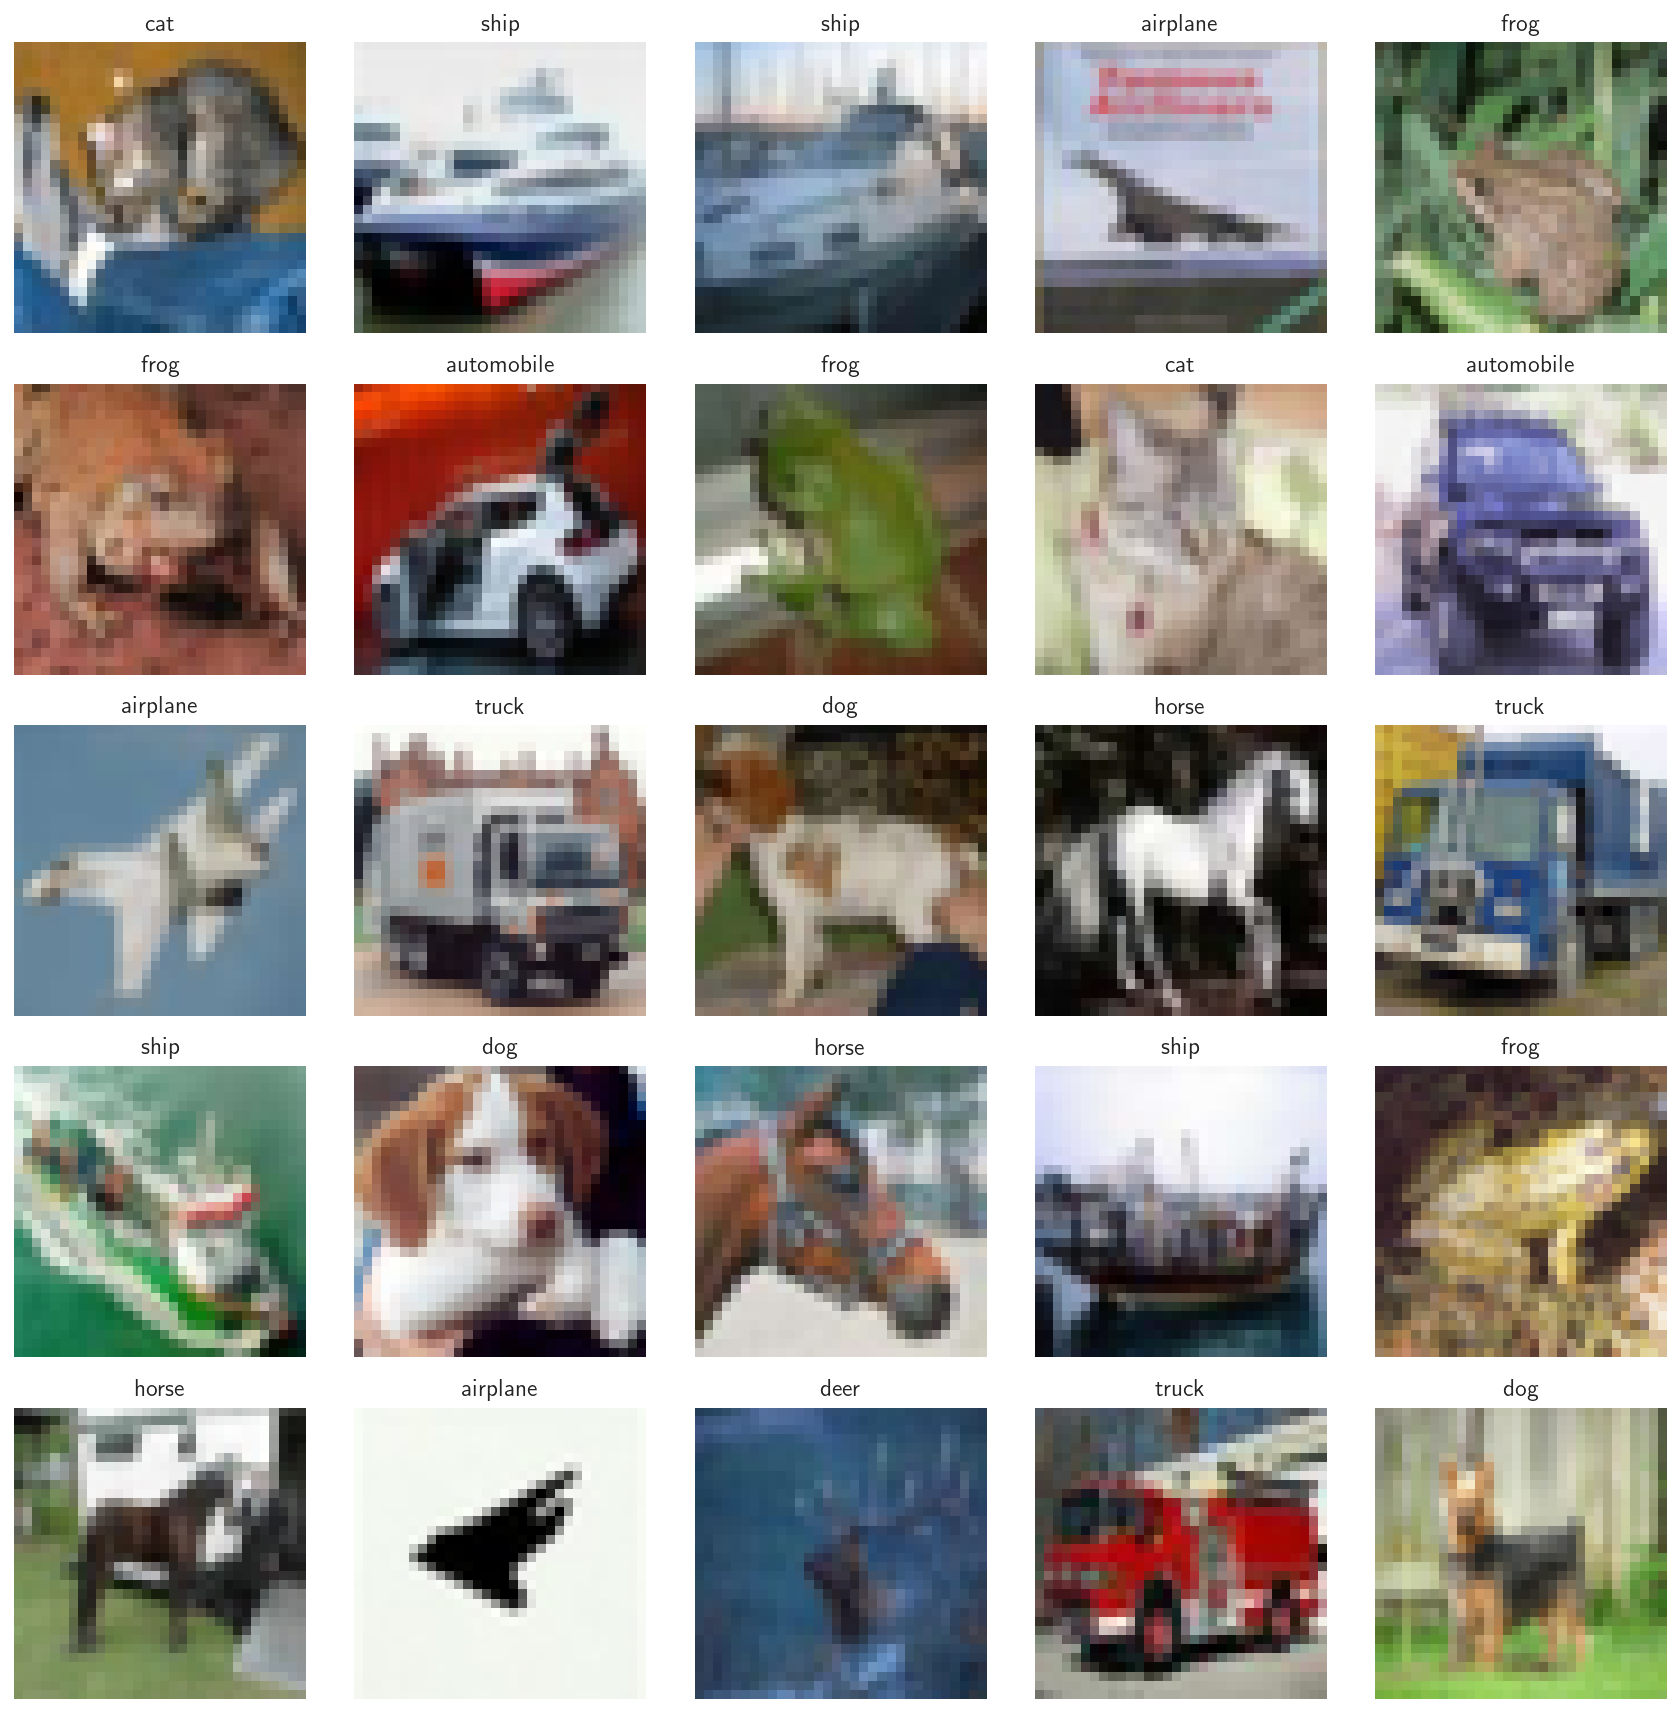

In [28]:
def load(file_name):
    data = []
    
    for file in glob.glob('cifar-10-batches-py/' + file_name):
        with open(file, 'rb') as fo:
            data.append(pickle.load(fo, encoding='bytes'))
            
    images = np.array(data[0][b'data'])
    labels = np.array(data[0][b'labels'])

    if len(data) > 1:
        for i in range(1, len(data)):
            images = np.concatenate((images, data[i][b'data']), axis=0)
            labels = np.concatenate((labels, data[i][b'labels']), axis=0)
    
    return (images.reshape(-1, 3, 32, 32)/255.0).astype(np.float32), labels.reshape((-1, 1))


Xtrain, Ttrain = load('data_batch_*')
Xtest, Ttest, = load('test_batch')

print(Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape)
    
with open('cifar-10-batches-py/batches.meta', 'rb') as f:
    class_names = pickle.load(f, encoding='bytes')
class_names = class_names[b'label_names']
classes = np.unique(Ttrain)
    
def imshow(Xset, Tset):
    plt.figure(figsize=(12, 12))
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.imshow(np.moveaxis(Xset[i,...], 0, 2), interpolation='nearest')
        plt.axis('off')
        unicode = class_names[Tset[i][0]].decode('utf-8')
        plt.title(unicode) 

    plt.tight_layout()
    
imshow(Xtest, Ttest)

In [41]:
ex = Xtrain[np.random.randint(len(Xtrain))]

In [80]:
ex = copy.copy(nice_image)

(-0.5, 31.5, 31.5, -0.5)

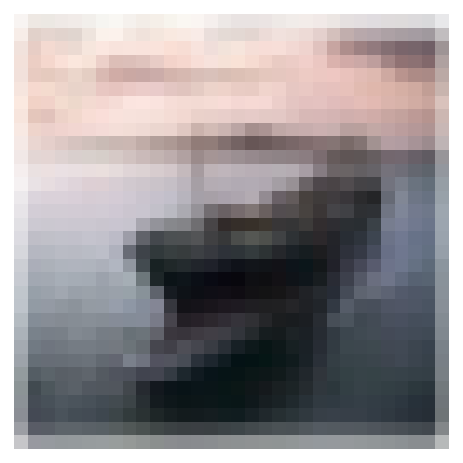

In [81]:
plt.imshow(np.moveaxis(ex, 0, 2), interpolation='nearest')
plt.axis('off')

In [82]:
# ex = np.random.poisson(ex * 255) / 255.0

In [83]:
noise = np.random.normal(0, 0.05, ex.shape)

In [84]:
ex = ex + noise

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 31.5, 31.5, -0.5)

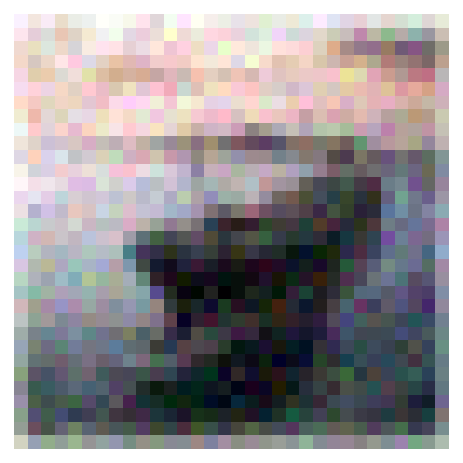

In [85]:
plt.imshow(np.moveaxis(ex, 0, 2), interpolation='nearest')
plt.axis('off')

In [26]:
nnet = nnc.NeuralNetwork_Convolutional(n_channels_in_image=Xtrain.shape[1],
                                   image_size=Xtrain.shape[2],
                                   n_units_in_conv_layers=[25, 25, 25],
                                   kernels_size_and_stride=[(4, 2), (5, 2), (2, 1)],
                                   n_units_in_fc_hidden_layers=[],
                                   classes=classes,
                                   use_gpu=True)
rho = 0.001
epochs = 2000
nnet.train(Xtrain, Ttrain, epochs, learning_rate=rho, verbose=True)

Epoch 200 error 1.23982
Epoch 400 error 1.04984
Epoch 600 error 0.95504
Epoch 800 error 0.89153
Epoch 1000 error 0.85649
Epoch 1200 error 0.80786
Epoch 1400 error 0.77511
Epoch 1600 error 0.74691
Epoch 1800 error 0.72274
Epoch 2000 error 0.70182


In [31]:
classes, Y    = nnet.use(Xtrain)
train_percent = ml.percent_correct(Ttrain, classes)
classes, Y    = nnet.use(Xtest)
test_percent  = ml.percent_correct(Ttest, classes)
print(f'Train Percentage: {train_percent}, Test Percentage: {test_percent}')

Train Percentage: 75.94999999999999, Test Percentage: 62.33


In [32]:
_ = ml.confusion_matrix(Ttest, classes, np.unique(Ttest))

       0    1    2    3    4    5    6    7    8    9
    ------------------------------------------------------------
 0 | 67.9  3.9  5.4  1.9  2.4  0.8  2.1  1.8  9.6  4.2
 1 |  4.9 71.6  1.1  1.3  0.4  0.5  1.2  1.0  3.8 14.2
 2 |  7.0  1.1 51.4  6.5 10.7  7.3  8.2  5.0  1.7  1.1
 3 |  2.1  1.5 10.7 43.2  6.4 18.2  9.4  4.0  1.6  2.9
 4 |  3.1  0.4 10.4  6.2 54.1  5.1  7.2 11.0  1.5  1.0
 5 |  1.5  0.4  6.9 19.7  6.6 50.7  4.5  6.7  1.6  1.4
 6 |  1.7  1.0  6.6  7.4  4.8  3.3 71.6  1.3  1.0  1.3
 7 |  2.7  0.5  4.3  5.3  8.3  7.5  1.7 66.5  0.8  2.4
 8 |  8.5  4.5  2.3  1.7  0.9  1.3  0.8  0.6 76.4  3.0
 9 |  3.4 12.7  1.3  2.3  0.6  1.1  1.1  2.6  5.0 69.9


Total of 114 misclassified samples,
      with a 3.310% difference from test by changing 1 pixel(s)
(10000, 3, 32, 32) (10000, 3, 32, 32)


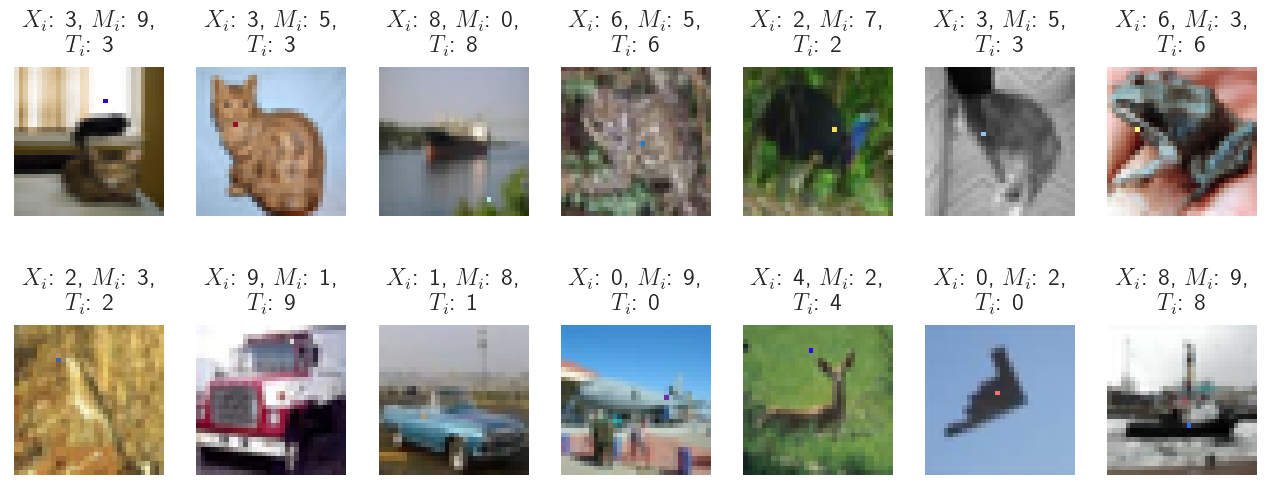

[b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog', b'frog', b'horse', b'ship', b'truck']


FloatProgress(value=0.0, max=125.0)

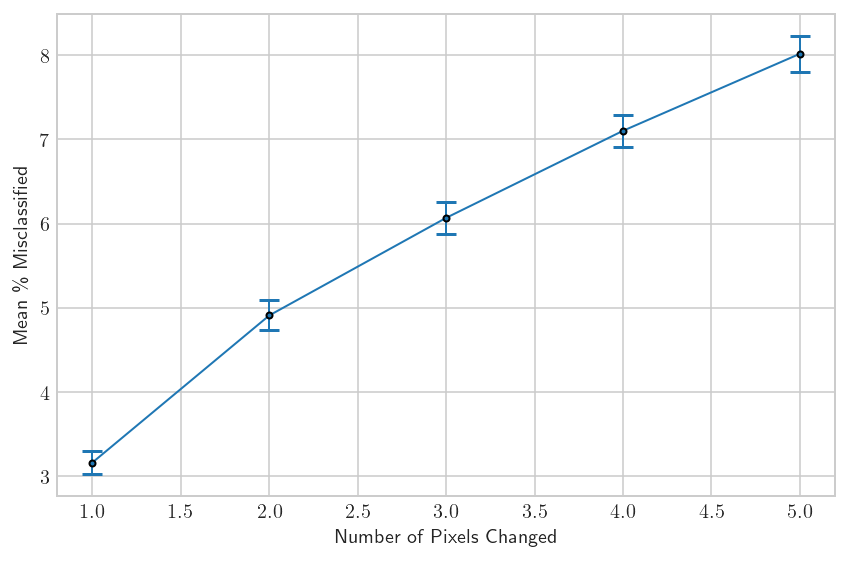

In [35]:
pixels_to_change = 1
Xcopy = per.change_pixel(Xtest, pixels_to_change=pixels_to_change)
diff_index, percent_diff = per.classified_diff(nnet, Xtest, Xcopy, Ttest)
print(f'''Total of {len(diff_index)} misclassified samples,
      with a {percent_diff:.3f}% difference from test by changing {pixels_to_change} pixel(s)''')
per.imshow(nnet, Xtest, Xcopy, Ttest, diff_index, model='CIFAR',
           name='media/cifar_example_1px_stuck.pdf')
print(class_names)
per.change_in_pixels_plot(nnet, Xtest, Ttest, end_pixel_val=5,
                          errorbar=True, pertrub='stuck',trials_per_pixel=25,
                          name='media/cifar_change_5px_stuck.pdf')